# Exploring ASAP dataset

Dataset of [Aligned Scores and Performances](https://github.com/fosfrancesco/asap-dataset/tree/master)

In [1]:
import sys
sys.path.append("..")

from src.data import extract_piano_roll, calculate_cross_similarity, construct_beat_alignment
from src.utils import plot_piano_roll, plot_cross_similarity, seconds_to_frames
from src.transforms import RandomJumps
from src.asap import load_annotations, ASAPWrapper

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [3]:
annotations = load_annotations(asap_dir)

In [4]:
print(f"Number of performances in ASAP: {len(annotations)}")

Number of performances in ASAP: 1067


Let's take a look at one of the performances of Schubert's Impromptu Op. 90 No. 2

In [5]:
piece_title = 'Schubert/Impromptu_op.90_D.899/2'
performer = 'Denisova11M.mid'
perf_title = os.path.join(piece_title, performer)
perf_path = os.path.join(asap_dir, perf_title)

score_path = os.path.join(asap_dir, piece_title, 'midi_score.mid')

In [6]:
list(annotations[perf_title].keys())

['performance_beats',
 'performance_downbeats',
 'performance_beats_type',
 'perf_time_signatures',
 'perf_key_signatures',
 'midi_score_beats',
 'midi_score_downbeats',
 'midi_score_beats_type',
 'midi_score_time_signatures',
 'midi_score_key_signatures',
 'downbeats_score_map',
 'score_and_performance_aligned']

In [7]:
perf_beats = np.array(annotations[perf_title]['performance_beats'])

print("Number of annotated beats in performance:", len(perf_beats))

Number of annotated beats in performance: 848


In [8]:
score_beats = np.array(annotations[perf_title]['midi_score_beats'])

print("Number of annotated beats in the score:", len(score_beats))

Number of annotated beats in the score: 848


As we can see, the number of annotated beats match.

# Cross-similarity

In [9]:
# Sampling frequency for piano rolls
fs = 40

In [10]:
perf_roll = extract_piano_roll(perf_path, fs=fs)
perf_roll.shape

torch.Size([8934, 128])

/home/dmgvrlv/code/dcnn-alignment/notebooks/../src/utils.py:19: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll.T.numpy()[start_pitch:end_pitch + 1],


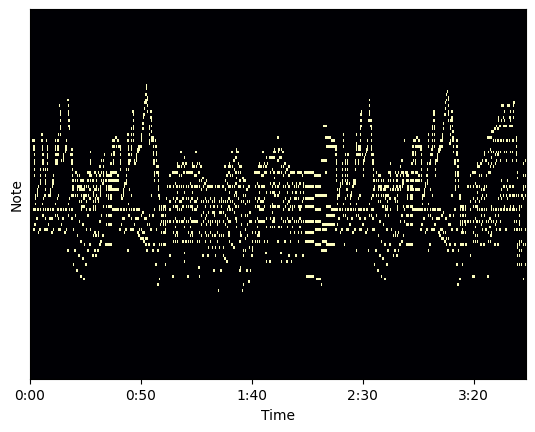

In [11]:
plot_piano_roll(perf_roll, fs)

In [12]:
score_roll = extract_piano_roll(score_path)
score_roll.shape

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


torch.Size([16959, 128])

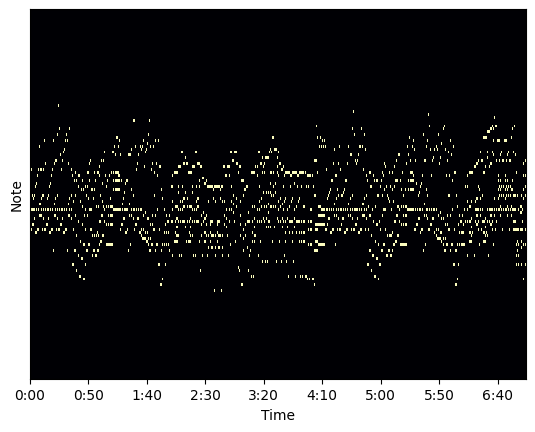

In [13]:
plot_piano_roll(score_roll, fs)

In [14]:
cross_similarity = calculate_cross_similarity(perf_roll, score_roll)
cross_similarity.shape

torch.Size([1, 8934, 16959])

In [15]:
beat_alignment = construct_beat_alignment(perf_beats, score_beats, fs)
beat_alignment.shape

(2, 848)

In [16]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

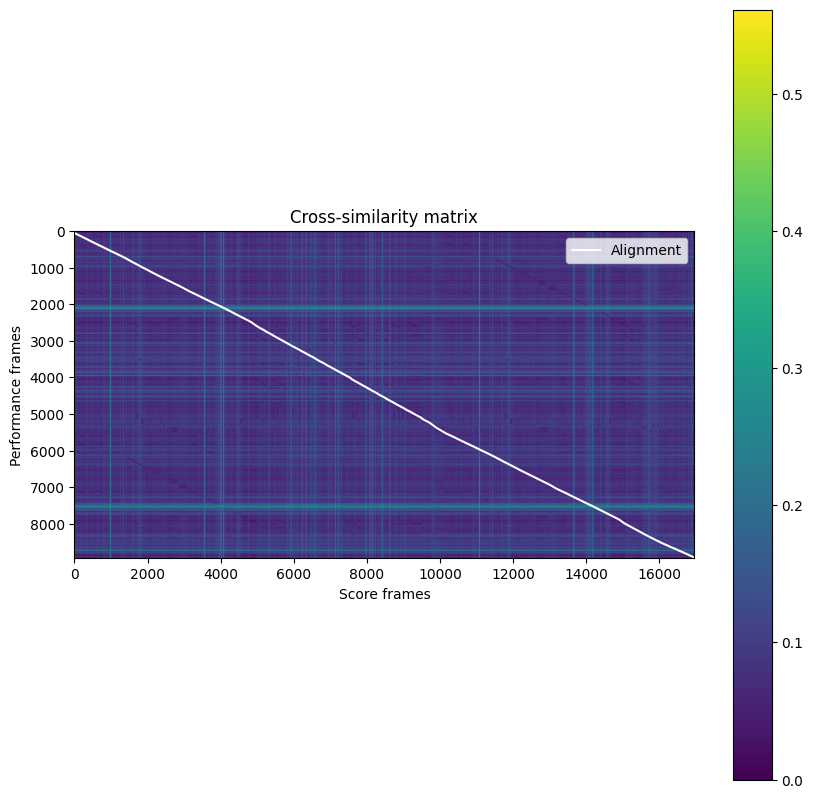

In [17]:
plot_cross_similarity(cross_similarity, beat_alignment=beat_alignment)

In [18]:
cross_similarity

tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         ...,
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180]]])

# Augmentations

In [19]:
jumps_transform = RandomJumps(fs, max_num_jumps=2, max_silence_s=8.)

In [20]:
aug_perf_roll, aug_beat_alignment, inflection_points = jumps_transform(perf_roll, score_roll, beat_alignment)

In [21]:
print(f'Piano roll shape: {perf_roll.shape}')
print(f'Augmented piano roll shape: {aug_perf_roll.shape}')

Piano roll shape: torch.Size([8934, 128])
Augmented piano roll shape: torch.Size([13686, 128])


In [22]:
print(f'Beat alignment shape: {beat_alignment.shape}')
print(f'Augmented beat alignment shape: {aug_beat_alignment.shape}')

Beat alignment shape: (2, 848)
Augmented beat alignment shape: (2, 1236)


In [23]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

In [24]:
aug_beat_alignment

array([[    0,    16,    26, ..., 13513, 13523, 13534],
       [    0,    20,    40, ..., 16880, 16900, 16920]])

In [25]:
inflection_points

tensor([[0.0336, 0.0542],
        [0.0574, 0.0271],
        [0.4198, 0.5731],
        [0.4318, 0.1439]])

In [26]:
aug_cross_similarity = calculate_cross_similarity(aug_perf_roll, score_roll)
aug_cross_similarity.shape

torch.Size([1, 13686, 16959])

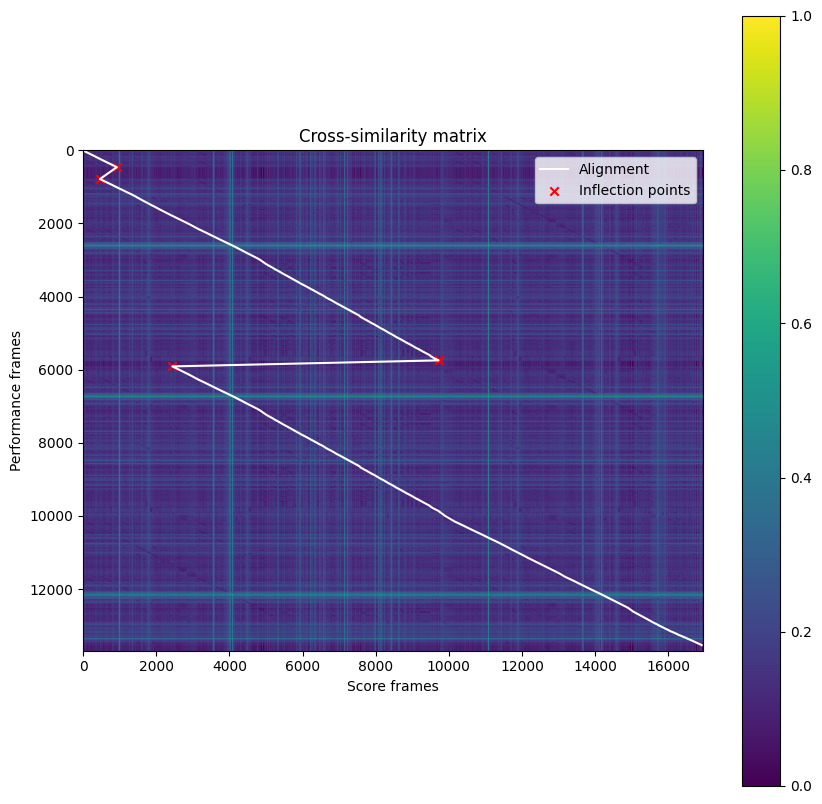

In [27]:
plot_cross_similarity(aug_cross_similarity,
                      beat_alignment=aug_beat_alignment,
                      inflection_points=inflection_points)

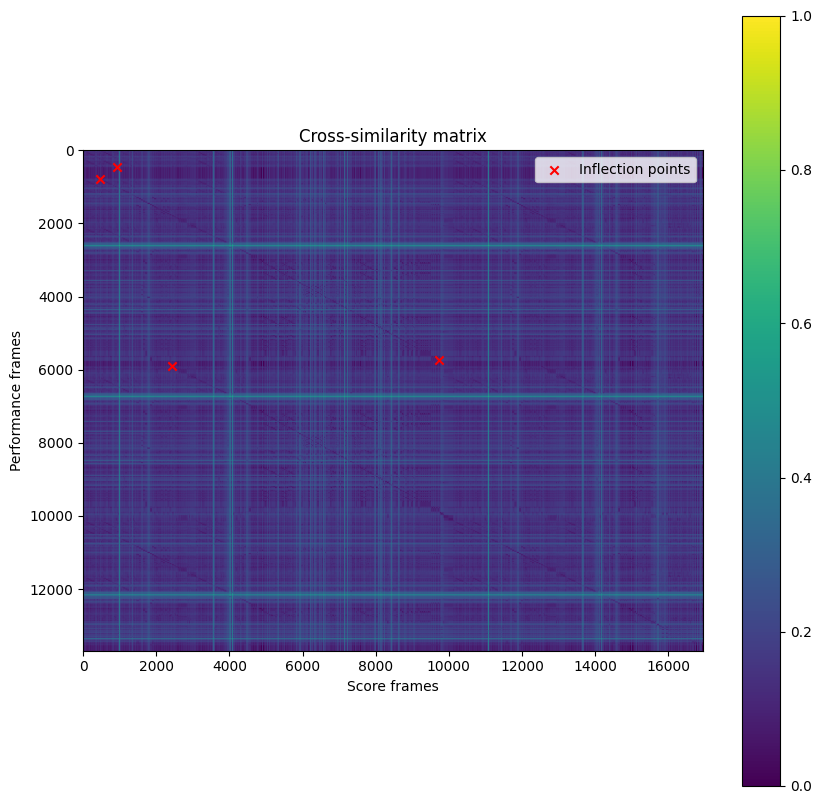

In [28]:
plot_cross_similarity(aug_cross_similarity,
                      beat_alignment=None,
                      inflection_points=inflection_points)

# Dataset

In [29]:
asap_wrapper = ASAPWrapper(asap_dir, val_ratio=0.2, random_seed=42)

In [30]:
print(f'Number of performances in train: {len(asap_wrapper.train_paths)}')
print(f'Number of performances in val: {len(asap_wrapper.val_paths)}')

Number of performances in train: 812
Number of performances in val: 224


In [31]:
from typing import List, Dict, Optional, Callable
from torch.utils.data import Dataset


class CrossSimilarityDataset(Dataset):
    """Performance-score cross-similarity matrices dataset."""

    def __init__(self,
                 pairs: List[Dict],
                 fs: int,
                 transform: Callable,
                 structural_transform: Optional[Callable] = None,
                 inference_only: bool = False):
        """Initializes an instance of dataset class.

        Args:
            pairs: A list of performance-score path pairs and (optionally) their aligned
              beat arrays. Each dictionary in a list must contain keys `perf`, `score`.
              If `structural_transform` is not None, then `perf_beats`, and `score_beats`
              must also be keys.
            fs: Piano roll sampling frequency.
            transform: Transformation to apply to cross-similarity matrices (e.g., resize).
            structural_transform: Structural transformations to apply to performance
              piano rolls.
            inference_only: If True, dataset does not contain ground truth inflection points.
        """
        self.pairs = pairs
        self.fs = fs
        self.transform = transform
        self.structural_transform = structural_transform
        self.inference_only = inference_only

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        perf_path = self.pairs[idx]['perf']
        score_path = self.pairs[idx]['score']
        if self.structural_transform is not None:
            perf_beats = np.array(self.pairs[idx]['perf_beats'])
            score_beats = np.array(self.pairs[idx]['score_beats'])

        perf_roll = extract_piano_roll(perf_path, fs=fs)
        score_roll = extract_piano_roll(score_path, fs=fs)

        if self.structural_transform is not None:
            beat_alignment = construct_beat_alignment(perf_beats, score_beats, fs)
            perf_roll, beat_alignment, inflection_points = self.structural_transform(perf_roll, beat_alignment)

        cross_similarity = calculate_cross_similarity(perf_roll, score_roll)
        cross_similarity = self.transform(cross_similarity)
        sample = {'image': cross_similarity}

        if not self.inference_only:
            sample['target'] = inflection_points

        return sample